In [2]:
import tensorflow as tf
from tensorflow.core import util
import keras
from keras import layers, models, utils, backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt

C:\Users\DELL\.conda\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 166)               27722     
                                                                 
 drop1 (Dropout)             (None, 166)               0         
                                                                 
 h2 (Dense)                  (None, 83)                13861     
                                                                 
 drop2 (Dropout)             (None, 83)                0         
                                                                 
 h3 (Dense)                  (None, 58)                4872      
                                                                 
 drop3 (Dropout)             (None, 58)                0         
                                                                 
 output (Dense)              (None, 1)                 59   

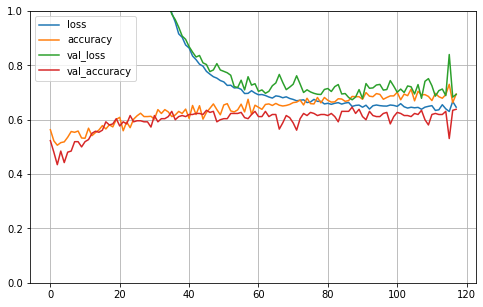

9/9 [==============================] - 0s 2ms/step
        SE        SP       ACC       AUC        F1       MCC        BA
0  0.80663  0.405063  0.684615  0.638786  0.780749  0.222609  0.605847


In [12]:
model = models.Sequential(name="DeepNN", layers=[
    # 1st hidden layer
    layers.Dense(name="h1", input_dim=166, kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-1),
                 units=int(round((166 * 1))),
                 activation='tanh'),
    layers.Dropout(name="drop1", rate=0.5),
    # 2st hidden layer
    layers.Dense(name="h2", units=int(round((166 * 0.5))),
                 activation='relu'),
    layers.Dropout(name="drop2", rate=0.6),
    # 3st hidden layer
    layers.Dense(name="h3", units=int(round((166 * 0.35))),
                 activation='relu'),
    layers.Dropout(name="drop3", rate=0.4),
    # final layer
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model.summary()
# compiling Neural Networks
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# data loading
data = pd.read_csv(r'''D:\A309-21-\课题\DILI Predict\DILI数据+模型\汇总-DILI\train\Padel-MACCSdata.csv''', low_memory=False)
X = data.iloc[:,3:].values
y = data.loc[:,'DILIst.1'].values
# fixed random seed so that training is the same for each division, shuffle: reorder the data before splitting
BATCH_SIZE = 18
data_loader = DataLoader(dataset=data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False)
dataset = data.sample(frac=1).reset_index(drop=True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=12)
class_weights = {0:1.521, 1:0.745}
# monitor: monitoring parameter, patience: exit if no boost in n-cycle, restore_best_weights: fetch optimal weights
EarlyStop = [EarlyStopping(monitor='val_loss', min_delta=0, patience=30, mode='min', verbose=1, restore_best_weights = True)]
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=BATCH_SIZE, class_weight=class_weights, callbacks=EarlyStop, verbose=1, shuffle=True)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()
# test
y_score_test = model.predict(X_test)
y_pred_test = (y_score_test > 0.5).astype("int32")
# model evaluation
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_test).ravel()
SE = TP / (TP + FN)
SP = TN / (TN + FP)
ACC = (TP + TN) / (TP + TN + FP + FN)
F1 = 2 * (TP / (2 * TP + FN + FP))
MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
AUC = roc_auc_score(y_test, y_score_test)
BA = balanced_accuracy_score(y_test, y_pred_test)
LR = pd.DataFrame({'SE': [SE], 'SP': [SP], 'ACC': [ACC], 'AUC': [AUC], 'F1': [F1], 'MCC': [MCC], 'BA': [BA]})
print(LR)
